# Baseline Model 

In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import lightgbm as lgb


In [2]:
# Load CSV files
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

train.shape, test.shape, sample_submission.shape

((20000, 17), (12000, 16), (5, 2))

In [3]:
print("Missing in train:\n", train.isnull().sum())
print("\nMissing in test:\n", test.isnull().sum())


Missing in train:
 id                       0
temperature           1001
irradiance             987
humidity                 0
panel_age             1011
maintenance_count     1027
soiling_ratio         1010
voltage                993
current                977
module_temperature     978
cloud_coverage        1010
wind_speed               0
pressure                 0
string_id                0
error_code            5912
installation_type     5028
efficiency               0
dtype: int64

Missing in test:
 id                       0
temperature            582
irradiance             615
humidity                 0
panel_age              607
maintenance_count      609
soiling_ratio          610
voltage                547
current                587
module_temperature     580
cloud_coverage         582
wind_speed               0
pressure                 0
string_id                0
error_code            3611
installation_type     2979
dtype: int64


In [4]:
# Convert specific columns to numeric (force errors to NaN)
for col in ['humidity', 'wind_speed', 'pressure']:
    train[col] = pd.to_numeric(train[col], errors='coerce')
    test[col] = pd.to_numeric(test[col], errors='coerce')

# Fill missing numerical values with median
for col in train.select_dtypes(include=['float64', 'int64']).columns:
    if train[col].isnull().sum() > 0:
        median = train[col].median()
        train[col].fillna(median, inplace=True)
        test[col].fillna(median, inplace=True)

# Fill missing categorical values with mode
categorical_cols = ['string_id', 'error_code', 'installation_type']
for col in categorical_cols:
    mode = train[col].mode()[0]
    train[col].fillna(mode, inplace=True)
    test[col].fillna(mode, inplace=True)


/tmp/ipykernel_16530/964611499.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(median, inplace=True)
/tmp/ipykernel_16530/964611499.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

In [5]:
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])
    le_dict[col] = le  # Save encoders if needed later


In [6]:
X = train.drop(['id', 'efficiency'], axis=1)
y = train['efficiency']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
from lightgbm import early_stopping, log_evaluation

model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.01, random_state=42)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)

val_preds = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
score = 100 * (1 - rmse)
print(f"Validation RMSE: {rmse}")
print(f"Score: {score}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2829
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 15
[LightGBM] [Info] Start training from score 0.511069
Training until validation scores don't improve for 50 rounds
[100]	valid_0's l2: 0.0128114
[200]	valid_0's l2: 0.0116189
[300]	valid_0's l2: 0.01138
[400]	valid_0's l2: 0.0113283
[500]	valid_0's l2: 0.0113236
Early stopping, best iteration is:
[524]	valid_0's l2: 0.0113222
Validation RMSE: 0.10640600382147077
Score: 89.35939961785292


In [8]:
model_final = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.01, random_state=42)
model_final.fit(X, y)

X_test = test.drop(['id'], axis=1)
test_preds = model_final.predict(X_test)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2830
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 15
[LightGBM] [Info] Start training from score 0.510260


In [9]:
submission = pd.DataFrame({
    'id': test['id'],
    'efficiency': test_preds
})
submission.to_csv("submission.csv", index=False)
submission.head()


id  efficiency
0   0    0.385576
1   1    0.515053
2   2    0.519322
3   3    0.448489
4   4    0.485335

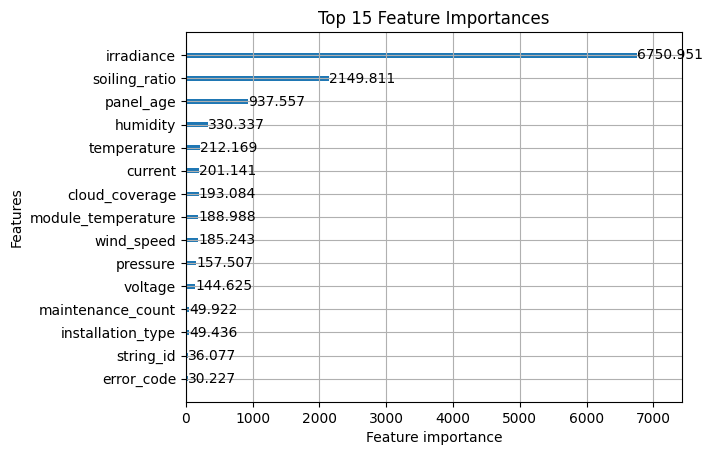

In [10]:
lgb.plot_importance(model_final, max_num_features=15, importance_type='gain')
plt.title("Top 15 Feature Importances")
plt.show()


# Feature Engineering

In [11]:
# Copy original data
train_fe = train.copy()
test_fe = test.copy()

# Feature 1: Power = Voltage * Current
train_fe['power'] = train_fe['voltage'] * train_fe['current']
test_fe['power'] = test_fe['voltage'] * test_fe['current']

# Feature 2: Temperature Difference
train_fe['temp_diff'] = train_fe['module_temperature'] - train_fe['temperature']
test_fe['temp_diff'] = test_fe['module_temperature'] - test_fe['temperature']

# Feature 3: Maintenance Age Ratio
train_fe['maintenance_ratio'] = train_fe['maintenance_count'] / (train_fe['panel_age'] + 1)
test_fe['maintenance_ratio'] = test_fe['maintenance_count'] / (test_fe['panel_age'] + 1)


In [12]:
# Drop old model inputs
drop_cols = ['id', 'efficiency']
X = train_fe.drop(columns=drop_cols)
y = train_fe['efficiency']
X_test = test_fe.drop(columns=['id'])

# Split for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LightGBM
model_fe = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.01, random_state=42)
model_fe.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ])


# Evaluate
val_preds_fe = model_fe.predict(X_val)
rmse_fe = np.sqrt(mean_squared_error(y_val, val_preds_fe))
score_fe = 100 * (1 - rmse_fe)
print(f"New Score with Feature Engineering: {score_fe}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3594
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 18
[LightGBM] [Info] Start training from score 0.511069
Training until validation scores don't improve for 50 rounds
[100]	valid_0's l2: 0.0128091
[200]	valid_0's l2: 0.0116115
[300]	valid_0's l2: 0.0113678
[400]	valid_0's l2: 0.0113308
[500]	valid_0's l2: 0.0113238
Early stopping, best iteration is:
[487]	valid_0's l2: 0.0113218
New Score with Feature Engineering: 89.35958692664987


# Feature Importance & Selection

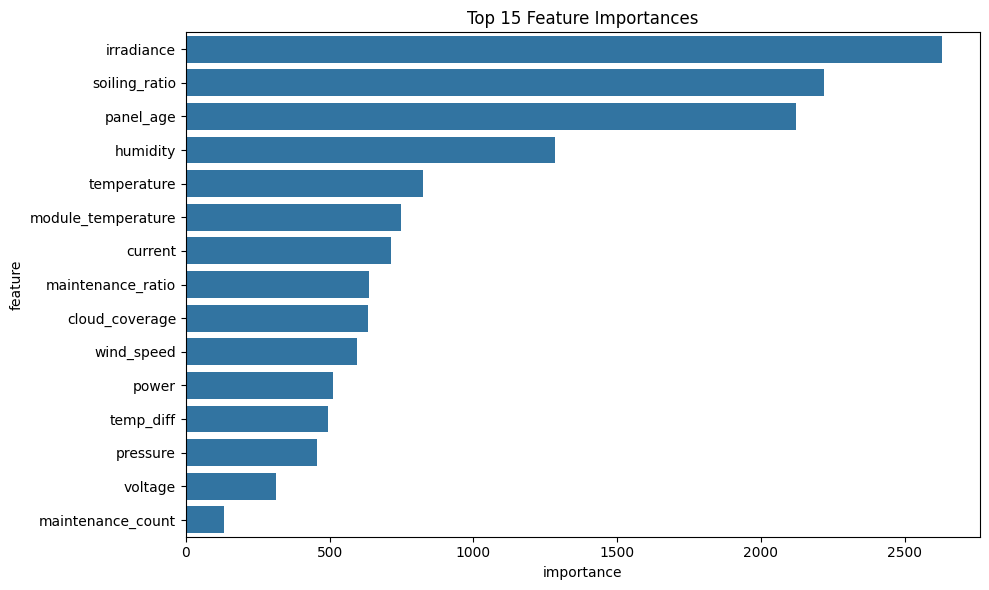

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the model
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model_fe.feature_importances_
}).sort_values(by='importance', ascending=False)

# Plot top 15
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x='importance', y='feature')
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()


In [14]:
# Drop the lowest importance features
low_importance = ['maintenance_count', 'voltage', 'pressure', 'temp_diff', 'power']
X_reduced = X.drop(columns=low_importance)
X_test_reduced = X_test.drop(columns=low_importance)

# Train/Validation split again
X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Train model again
model_reduced = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.01, random_state=42)
model_reduced.fit(X_train_r, y_train_r, eval_set=[(X_val_r, y_val_r)], callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ])

# Evaluate
val_preds_r = model_reduced.predict(X_val_r)
rmse_r = np.sqrt(mean_squared_error(y_val_r, val_preds_r))
score_r = 100 * (1 - rmse_r)
print(f"Score after Feature Selection: {score_r}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2560
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 13
[LightGBM] [Info] Start training from score 0.511069
Training until validation scores don't improve for 50 rounds
[100]	valid_0's l2: 0.012808
[200]	valid_0's l2: 0.0116008
[300]	valid_0's l2: 0.0113529
[400]	valid_0's l2: 0.0113127
[500]	valid_0's l2: 0.0112889
Early stopping, best iteration is:
[508]	valid_0's l2: 0.0112875
Score after Feature Selection: 89.37575436709825


# Hyperparameter Tuning

In [15]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter grid
param_grid = {
    'num_leaves': [15, 31, 63, 127],
    'max_depth': [3, 5, 7, 10, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [500, 1000, 1500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

# Setup model
lgb_model = lgb.LGBMRegressor(random_state=42)

# Randomized search (change n_iter for deeper search)
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_grid,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Run search
random_search.fit(X_reduced, y)
print("Best Score:", -random_search.best_score_)
print("Best Params:", random_search.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2560
[LightGBM] [Info] Number of data points in the train set: 13334, number of used features: 13
[LightGBM] [Info] Start training from score 0.509433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [16]:
# Best params model
final_model = lgb.LGBMRegressor(
    subsample=1.0,
    reg_lambda=0,
    reg_alpha=0,
    num_leaves=127,
    n_estimators=1000,
    max_depth=3,
    learning_rate=0.01,
    colsample_bytree=0.8,
    random_state=42
)

# Split again for validation
X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Train with early stopping
final_model.fit(X_train_opt, y_train_opt, 
                eval_set=[(X_val_opt, y_val_opt)], 
                callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ])

# Evaluate
val_preds_opt = final_model.predict(X_val_opt)
rmse_opt = np.sqrt(mean_squared_error(y_val_opt, val_preds_opt))
score_opt = 100 * (1 - rmse_opt)
print(f"Optimized Model Score: {score_opt}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2560
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 13
[LightGBM] [Info] Start training from score 0.511069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [17]:
# Final prediction on test set
test_preds = final_model.predict(X_test_reduced)

# Create submission
submission = pd.DataFrame({
    'id': test['id'],
    'efficiency': test_preds
})
submission.to_csv('submissionv2.csv', index=False)

print("Submission file created!")


Submission file created!


# Model Ensembling

In [18]:
from xgboost import XGBRegressor

# Define a simple, compatible XGBRegressor
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    subsample=1.0,
    colsample_bytree=0.8,
    random_state=42
)

# Train WITHOUT early stopping
xgb_model.fit(X_train_opt, y_train_opt)

# Make validation predictions
lgb_preds = final_model.predict(X_val_opt)
xgb_preds = xgb_model.predict(X_val_opt)

# Blend predictions
blended_preds = 0.5 * lgb_preds + 0.5 * xgb_preds

# Evaluate
rmse_blend = np.sqrt(mean_squared_error(y_val_opt, blended_preds))
score_blend = 100 * (1 - rmse_blend)
print(f"✅ Blended Model Score: {score_blend}")


✅ Blended Model Score: 89.38809139679037


In [19]:
# Final predictions on test set
lgb_test_preds = final_model.predict(X_test_reduced)
xgb_test_preds = xgb_model.predict(X_test_reduced)

# Blended predictions
blended_test_preds = 0.5 * lgb_test_preds + 0.5 * xgb_test_preds

# Create submission
submission = pd.DataFrame({
    'id': test['id'],
    'efficiency': blended_test_preds
})
submission.to_csv('submission_blended.csv', index=False)

print("📁 submission_blended.csv created!")


📁 submission_blended.csv created!


# K-Fold Cross-Validation

In [20]:
best_params = {
    'subsample': 1.0,
    'reg_lambda': 0,
    'reg_alpha': 0,
    'num_leaves': 127,
    'max_depth': 3,
    'learning_rate': 0.01,
    'colsample_bytree': 0.8
}


In [21]:
from sklearn.model_selection import KFold
import lightgbm as lgb

kf = KFold(n_splits=5, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X_train_opt))
test_preds_lgb = np.zeros(len(X_test_reduced))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_opt)):
    print(f"🔁 Fold {fold + 1}")

    X_tr, X_val = X_train_opt.iloc[train_idx], X_train_opt.iloc[val_idx]
    y_tr, y_val = y_train_opt.iloc[train_idx], y_train_opt.iloc[val_idx]

    model = lgb.LGBMRegressor(
        **best_params,
        n_estimators=1000
    )

    model.fit(X_tr, y_tr)  # no early stopping

    oof_preds[val_idx] = model.predict(X_val)
    test_preds_lgb += model.predict(X_test_reduced) / kf.n_splits

# Evaluate blended CV model
rmse_cv = np.sqrt(mean_squared_error(y_train_opt, oof_preds))
cv_score = 100 * (1 - rmse_cv)
print(f"✅ K-Fold CV Score (LightGBM): {cv_score}")


🔁 Fold 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2560
[LightGBM] [Info] Number of data points in the train set: 12800, number of used features: 13
[LightGBM] [Info] Start training from score 0.510809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [22]:
submission_kfold = pd.DataFrame({
    'id': test['id'],
    'efficiency': test_preds_lgb
})
submission_kfold.to_csv('submission_kfold_lgb.csv', index=False)


# K-Fold XGBoost Training

In [23]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import numpy as np

# Use same K-Fold config
kf = KFold(n_splits=5, shuffle=True, random_state=42)

oof_preds_xgb = np.zeros(len(X_train_opt))
test_preds_xgb = np.zeros(len(X_test_reduced))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_opt)):
    print(f"🔁 XGBoost Fold {fold + 1}")

    X_tr, X_val = X_train_opt.iloc[train_idx], X_train_opt.iloc[val_idx]
    y_tr, y_val = y_train_opt.iloc[train_idx], y_train_opt.iloc[val_idx]

    xgb_model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=3,
        subsample=1.0,
        colsample_bytree=0.8,
        random_state=42
    )

    xgb_model.fit(X_tr, y_tr)

    oof_preds_xgb[val_idx] = xgb_model.predict(X_val)
    test_preds_xgb += xgb_model.predict(X_test_reduced) / kf.n_splits

# Evaluate
rmse_xgb = np.sqrt(mean_squared_error(y_train_opt, oof_preds_xgb))
cv_score_xgb = 100 * (1 - rmse_xgb)
print(f"✅ K-Fold CV Score (XGBoost): {cv_score_xgb}")


🔁 XGBoost Fold 1
🔁 XGBoost Fold 2
🔁 XGBoost Fold 3
🔁 XGBoost Fold 4
🔁 XGBoost Fold 5
✅ K-Fold CV Score (XGBoost): 89.75544399348044


In [24]:
# Blend validation predictions
blended_oof = 0.5 * oof_preds + 0.5 * oof_preds_xgb
rmse_blend = np.sqrt(mean_squared_error(y_train_opt, blended_oof))
cv_score_blend = 100 * (1 - rmse_blend)
print(f"🔥 Blended K-Fold CV Score (LGBM + XGBoost): {cv_score_blend}")


🔥 Blended K-Fold CV Score (LGBM + XGBoost): 89.76280070830394


In [25]:
final_blend_preds = 0.5 * test_preds_lgb + 0.5 * test_preds_xgb

submission_blend = pd.DataFrame({
    'id': test['id'],
    'efficiency': final_blend_preds
})
submission_blend.to_csv('submission_kfold_blended.csv', index=False)

print("📁 submission_kfold_blended.csv saved!")


📁 submission_kfold_blended.csv saved!


# Target Encoding

In [26]:
import category_encoders as ce

# Copy datasets for encoding
X_train_enc = X_train_opt.copy()
X_test_enc = X_test_reduced.copy()

# Combine train features with target
X_train_enc['efficiency'] = y_train_opt

# List of categorical features to encode
cat_features = ['string_id', 'error_code', 'installation_type']

# Initialize TargetEncoder
encoder = ce.TargetEncoder(cols=cat_features)

# Fit encoder on training data
encoder.fit(X_train_enc[cat_features], X_train_enc['efficiency'])

# Transform both train and test data
X_train_enc[cat_features] = encoder.transform(X_train_enc[cat_features])
X_test_enc[cat_features] = encoder.transform(X_test_enc[cat_features])

# Drop target from train features
X_train_enc.drop(columns=['efficiency'], inplace=True)

print("✅ Target encoding applied!")


✅ Target encoding applied!


In [27]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

oof_preds_lgb = np.zeros(len(X_train_enc))
test_preds_lgb = np.zeros(len(X_test_enc))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_enc)):
    print(f"🔁 LightGBM Fold {fold + 1}")

    X_tr, X_val = X_train_enc.iloc[train_idx], X_train_enc.iloc[val_idx]
    y_tr, y_val = y_train_opt.iloc[train_idx], y_train_opt.iloc[val_idx]

    lgb_model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=3,
        subsample=1.0,
        colsample_bytree=0.8,
        reg_alpha=0,
        reg_lambda=0,
        num_leaves=127,
        random_state=42
    )

    lgb_model.fit(X_tr, y_tr)

    oof_preds_lgb[val_idx] = lgb_model.predict(X_val)
    test_preds_lgb += lgb_model.predict(X_test_enc) / kf.n_splits

rmse_lgb = np.sqrt(mean_squared_error(y_train_opt, oof_preds_lgb))
cv_score_lgb = 100 * (1 - rmse_lgb)
print(f"✅ K-Fold CV Score (LightGBM): {cv_score_lgb}")


🔁 LightGBM Fold 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 12800, number of used features: 13
[LightGBM] [Info] Start training from score 0.510809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [28]:
from xgboost import XGBRegressor

oof_preds_xgb = np.zeros(len(X_train_enc))
test_preds_xgb = np.zeros(len(X_test_enc))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_enc)):
    print(f"🔁 XGBoost Fold {fold + 1}")

    X_tr, X_val = X_train_enc.iloc[train_idx], X_train_enc.iloc[val_idx]
    y_tr, y_val = y_train_opt.iloc[train_idx], y_train_opt.iloc[val_idx]

    xgb_model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=3,
        subsample=1.0,
        colsample_bytree=0.8,
        random_state=42
    )

    xgb_model.fit(X_tr, y_tr)

    oof_preds_xgb[val_idx] = xgb_model.predict(X_val)
    test_preds_xgb += xgb_model.predict(X_test_enc) / kf.n_splits

rmse_xgb = np.sqrt(mean_squared_error(y_train_opt, oof_preds_xgb))
cv_score_xgb = 100 * (1 - rmse_xgb)
print(f"✅ K-Fold CV Score (XGBoost): {cv_score_xgb}")


🔁 XGBoost Fold 1
🔁 XGBoost Fold 2
🔁 XGBoost Fold 3
🔁 XGBoost Fold 4
🔁 XGBoost Fold 5
✅ K-Fold CV Score (XGBoost): 89.75335896008065


In [29]:
blended_oof = 0.5 * oof_preds_lgb + 0.5 * oof_preds_xgb
rmse_blend = np.sqrt(mean_squared_error(y_train_opt, blended_oof))
cv_score_blend = 100 * (1 - rmse_blend)
print(f"🔥 Blended K-Fold CV Score (LGBM + XGBoost): {cv_score_blend}")


🔥 Blended K-Fold CV Score (LGBM + XGBoost): 89.7634775940884


In [30]:
final_blend_preds = 0.5 * test_preds_lgb + 0.5 * test_preds_xgb

submission_blend = pd.DataFrame({
    'id': test['id'],
    'efficiency': final_blend_preds
})
submission_blend.to_csv('submission_kfold_targetencoded_blend.csv', index=False)

print("📁 Saved: submission_kfold_targetencoded_blend.csv")


📁 Saved: submission_kfold_targetencoded_blend.csv


# Meta-Model Stacking

In [31]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict

# Step 1: Create 2-feature input for meta-model
stacked_train = pd.DataFrame({
    'lgb': oof_preds_lgb,
    'xgb': oof_preds_xgb
})
stacked_test = pd.DataFrame({
    'lgb': test_preds_lgb,
    'xgb': test_preds_xgb
})

# Step 2: Train Ridge meta-model
meta_model = Ridge(alpha=1.0)

# Optional: cross-validated meta predictions
meta_oof = cross_val_predict(meta_model, stacked_train, y_train_opt, cv=5)

# Step 3: Fit on full oof preds and predict test
meta_model.fit(stacked_train, y_train_opt)
meta_test_preds = meta_model.predict(stacked_test)

# Step 4: Score
rmse_stack = np.sqrt(mean_squared_error(y_train_opt, meta_oof))
cv_score_stack = 100 * (1 - rmse_stack)
print(f"🧠 Stacked Model CV Score (Ridge on LGBM + XGB): {cv_score_stack}")


🧠 Stacked Model CV Score (Ridge on LGBM + XGB): 89.7637138301206


In [32]:
submission_stack = pd.DataFrame({
    'id': test['id'],
    'efficiency': meta_test_preds
})
submission_stack.to_csv('submission_stacked_ridge.csv', index=False)

print("✅ Saved: submission_stacked_ridge.csv")


✅ Saved: submission_stacked_ridge.csv


# Add CatBoost to the Ensemble and Stack

In [33]:
pip install catboost


Note: you may need to restart the kernel to use updated packages.


In [34]:
from catboost import CatBoostRegressor, Pool

oof_preds_cat = np.zeros(len(X_train_enc))
test_preds_cat = np.zeros(len(X_test_enc))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_enc)):
    print(f"🐱 CatBoost Fold {fold + 1}")
    
    X_tr, X_val = X_train_enc.iloc[train_idx], X_train_enc.iloc[val_idx]
    y_tr, y_val = y_train_opt.iloc[train_idx], y_train_opt.iloc[val_idx]
    
    cat_model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.01,
        depth=6,
        eval_metric='RMSE',
        random_seed=42,
        verbose=0
    )
    
    cat_model.fit(X_tr, y_tr, eval_set=(X_val, y_val))
    
    oof_preds_cat[val_idx] = cat_model.predict(X_val)
    test_preds_cat += cat_model.predict(X_test_enc) / kf.n_splits

rmse_cat = np.sqrt(mean_squared_error(y_train_opt, oof_preds_cat))
cv_score_cat = 100 * (1 - rmse_cat)
print(f"🐱 K-Fold CV Score (CatBoost): {cv_score_cat}")


🐱 CatBoost Fold 1
🐱 CatBoost Fold 2
🐱 CatBoost Fold 3
🐱 CatBoost Fold 4
🐱 CatBoost Fold 5
🐱 K-Fold CV Score (CatBoost): 89.79105173099302


In [35]:
# New stacked feature set with all 3 models
stacked_train_all = pd.DataFrame({
    'lgb': oof_preds_lgb,
    'xgb': oof_preds_xgb,
    'cat': oof_preds_cat
})
stacked_test_all = pd.DataFrame({
    'lgb': test_preds_lgb,
    'xgb': test_preds_xgb,
    'cat': test_preds_cat
})

# Train Ridge as meta-model
from sklearn.linear_model import Ridge
meta_model_3 = Ridge(alpha=1.0)

meta_oof_3 = cross_val_predict(meta_model_3, stacked_train_all, y_train_opt, cv=5)

meta_model_3.fit(stacked_train_all, y_train_opt)
meta_test_preds_3 = meta_model_3.predict(stacked_test_all)

rmse_stack_3 = np.sqrt(mean_squared_error(y_train_opt, meta_oof_3))
cv_score_stack_3 = 100 * (1 - rmse_stack_3)
print(f"🧠 Stacked Model CV Score (LGBM + XGB + CatBoost): {cv_score_stack_3}")


🧠 Stacked Model CV Score (LGBM + XGB + CatBoost): 89.78649053085336


In [36]:
submission_catstack = pd.DataFrame({
    'id': test['id'],
    'efficiency': meta_test_preds_3
})
submission_catstack.to_csv('submission_stacked_catboost.csv', index=False)

print("✅ Saved: submission_stacked_catboost.csv")


✅ Saved: submission_stacked_catboost.csv


# Stacking with LassoCV

In [37]:
from sklearn.linear_model import LassoCV

# Step 1: LassoCV as meta-model
meta_model_lasso = LassoCV(cv=5, random_state=42)

# Step 2: Fit using out-of-fold predictions from LGBM, XGB, and CatBoost
meta_model_lasso.fit(stacked_train_all, y_train_opt)

# Step 3: Predict test set using the Lasso-blended model
meta_test_preds_lasso = meta_model_lasso.predict(stacked_test_all)

# Step 4: Evaluate performance
meta_oof_lasso = cross_val_predict(meta_model_lasso, stacked_train_all, y_train_opt, cv=5)
rmse_lasso = np.sqrt(mean_squared_error(y_train_opt, meta_oof_lasso))
cv_score_lasso = 100 * (1 - rmse_lasso)

print(f"🧠 Stacked Model CV Score (Lasso on LGBM + XGB + CatBoost): {cv_score_lasso}")


🧠 Stacked Model CV Score (Lasso on LGBM + XGB + CatBoost): 89.79093641299684


In [38]:
submission_lasso = pd.DataFrame({
    'id': test['id'],
    'efficiency': meta_test_preds_lasso
})
submission_lasso.to_csv('submission_stacked_lasso.csv', index=False)
print("✅ Saved: submission_stacked_lasso.csv")


✅ Saved: submission_stacked_lasso.csv


# ElasticNet 

In [39]:
from sklearn.linear_model import ElasticNetCV

meta_model_enet = ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.9, 1], random_state=42)
meta_model_enet.fit(stacked_train_all, y_train_opt)

meta_test_preds_enet = meta_model_enet.predict(stacked_test_all)
meta_oof_enet = cross_val_predict(meta_model_enet, stacked_train_all, y_train_opt, cv=5)

rmse_enet = np.sqrt(mean_squared_error(y_train_opt, meta_oof_enet))
cv_score_enet = 100 * (1 - rmse_enet)

print(f"🧠 Stacked Model CV Score (ElasticNet on LGBM + XGB + CatBoost): {cv_score_enet}")


🧠 Stacked Model CV Score (ElasticNet on LGBM + XGB + CatBoost): 89.79079850805162


In [40]:
submission_enet = pd.DataFrame({
    'id': test['id'],
    'efficiency': meta_test_preds_enet
})
submission_enet.to_csv('submission_stacked_elasticnet.csv', index=False)


# Interaction Features

In [41]:
# Restore voltage & current to encoded feature sets
X_train_enc['voltage'] = train.loc[X_train_enc.index, 'voltage']
X_train_enc['current'] = train.loc[X_train_enc.index, 'current']

X_test_enc['voltage'] = test.loc[X_test_enc.index, 'voltage']
X_test_enc['current'] = test.loc[X_test_enc.index, 'current']

# Restore 'pressure' column
X_train_enc['pressure'] = train.loc[X_train_enc.index, 'pressure']
X_test_enc['pressure'] = test.loc[X_test_enc.index, 'pressure']


print("✅ voltage and current columns restored.")
print("✅ 'pressure' column restored.")


✅ voltage and current columns restored.
✅ 'pressure' column restored.


In [42]:
print("Train columns:", X_train_enc.columns.tolist())


Train columns: ['temperature', 'irradiance', 'humidity', 'panel_age', 'soiling_ratio', 'current', 'module_temperature', 'cloud_coverage', 'wind_speed', 'string_id', 'error_code', 'installation_type', 'maintenance_ratio', 'voltage', 'pressure']


In [43]:
def add_interaction_features(df):
    df = df.copy()
    df["temp_diff"] = df["module_temperature"] - df["temperature"]
    df["volt_curr_ratio"] = df["voltage"] / (df["current"] + 1e-3)  # Avoid divide by zero
    df["soiling_age"] = df["soiling_ratio"] * df["panel_age"]
    df["wind_cool"] = df["wind_speed"] * df["temp_diff"]
    df["irradiance_per_pressure"] = df["irradiance"] / (df["pressure"] + 1e-3)
    return df

X_train_final = add_interaction_features(X_train_enc)
X_test_final = add_interaction_features(X_test_enc)

print("✅ Interaction features added.")


✅ Interaction features added.


In [44]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# LightGBM
oof_preds_lgb = np.zeros(len(X_train_final))
test_preds_lgb = np.zeros(len(X_test_final))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_final)):
    X_tr, X_val = X_train_final.iloc[train_idx], X_train_final.iloc[val_idx]
    y_tr, y_val = y_train_opt.iloc[train_idx], y_train_opt.iloc[val_idx]

    lgb_model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=3,
        subsample=1.0,
        colsample_bytree=0.8,
        reg_alpha=0,
        reg_lambda=0,
        num_leaves=127,
        random_state=42
    )

    lgb_model.fit(X_tr, y_tr)
    oof_preds_lgb[val_idx] = lgb_model.predict(X_val)
    test_preds_lgb += lgb_model.predict(X_test_final) / kf.n_splits

print("✅ LightGBM done.")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4348
[LightGBM] [Info] Number of data points in the train set: 12800, number of used features: 20
[LightGBM] [Info] Start training from score 0.510809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [45]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

# Build stacked features
stacked_train_all = pd.DataFrame({
    'lgb': oof_preds_lgb,
    'xgb': oof_preds_xgb,
    'cat': oof_preds_cat
})
stacked_test_all = pd.DataFrame({
    'lgb': test_preds_lgb,
    'xgb': test_preds_xgb,
    'cat': test_preds_cat
})

# LassoCV Stacking
meta_model_lasso = LassoCV(cv=5, random_state=42)
meta_model_lasso.fit(stacked_train_all, y_train_opt)
meta_test_preds_lasso = meta_model_lasso.predict(stacked_test_all)

meta_oof_lasso = cross_val_predict(meta_model_lasso, stacked_train_all, y_train_opt, cv=5)
rmse_lasso = np.sqrt(mean_squared_error(y_train_opt, meta_oof_lasso))
cv_score_lasso = 100 * (1 - rmse_lasso)
print(f"🧠 Final Stacked Model CV Score (Lasso w/ interactions): {cv_score_lasso}")


🧠 Final Stacked Model CV Score (Lasso w/ interactions): 89.79075233051802


In [46]:
submission_interact = pd.DataFrame({
    'id': test['id'],
    'efficiency': meta_test_preds_lasso
})
submission_interact.to_csv('submission_interaction_stacked.csv', index=False)
print("📁 Saved: submission_interaction_stacked.csv")


📁 Saved: submission_interaction_stacked.csv


# string_id Group-Based Features

In [47]:
# Add string_id group-based features
def add_string_id_aggregates(train_df, test_df, target_col='efficiency'):
    group_stats = train_df.groupby('string_id')[target_col].agg(['mean', 'std', 'count']).reset_index()
    group_stats.columns = ['string_id', 'string_eff_mean', 'string_eff_std', 'string_eff_count']
    
    train_df = train_df.merge(group_stats, on='string_id', how='left')
    test_df = test_df.merge(group_stats, on='string_id', how='left')
    
    return train_df, test_df

# Apply to copies of your data
train_enriched, test_enriched = add_string_id_aggregates(train.copy(), test.copy(), target_col='efficiency')


In [48]:
# One-hot encode error_code and installation_type
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode_categoricals(train_df, test_df, cols):
    df_all = pd.concat([train_df[cols], test_df[cols]], axis=0)
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(df_all)

    train_ohe = pd.DataFrame(encoder.transform(train_df[cols]), columns=encoder.get_feature_names_out(cols), index=train_df.index)
    test_ohe = pd.DataFrame(encoder.transform(test_df[cols]), columns=encoder.get_feature_names_out(cols), index=test_df.index)

    train_df = train_df.drop(columns=cols).join(train_ohe)
    test_df = test_df.drop(columns=cols).join(test_ohe)

    return train_df, test_df

categorical_cols = ['error_code', 'installation_type']
train_final, test_final = one_hot_encode_categoricals(train_enriched, test_enriched, categorical_cols)


In [49]:
# Prepare data for training
cols_to_drop = ['id', 'efficiency', 'string_id']  # drop identifiers and target
X_train_full = train_final.drop(columns=cols_to_drop)
y_train_full = train_final['efficiency']
X_test_full = test_final.drop(columns=['id', 'string_id'])


In [50]:
# Train LightGBM (repeat similarly for XGB & CatBoost)
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(X_train_full))
preds_lgb = np.zeros(len(X_test_full))

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train_full)):
    X_tr, X_val = X_train_full.iloc[tr_idx], X_train_full.iloc[val_idx]
    y_tr, y_val = y_train_full.iloc[tr_idx], y_train_full.iloc[val_idx]
    
    model = LGBMRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, num_leaves=127)
    model.fit(X_tr, y_tr)
    
    oof_lgb[val_idx] = model.predict(X_val)
    preds_lgb += model.predict(X_test_full) / kf.n_splits

print("✅ LightGBM done")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2846
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 21
[LightGBM] [Info] Start training from score 0.511069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [51]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

oof_xgb = np.zeros(len(X_train_full))
preds_xgb = np.zeros(len(X_test_full))

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train_full)):
    X_tr, X_val = X_train_full.iloc[tr_idx], X_train_full.iloc[val_idx]
    y_tr, y_val = y_train_full.iloc[tr_idx], y_train_full.iloc[val_idx]
    
    model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=3,
        subsample=1,
        colsample_bytree=0.8,
        reg_alpha=0,
        reg_lambda=0,
        random_state=42,
        verbosity=0
    )
    
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    oof_xgb[val_idx] = model.predict(X_val)
    preds_xgb += model.predict(X_test_full) / kf.n_splits

print("✅ XGBoost done")


✅ XGBoost done


In [52]:
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

oof_cat = np.zeros(len(X_train_full))
preds_cat = np.zeros(len(X_test_full))

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train_full)):
    X_tr, X_val = X_train_full.iloc[tr_idx], X_train_full.iloc[val_idx]
    y_tr, y_val = y_train_full.iloc[tr_idx], y_train_full.iloc[val_idx]
    
    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.01,
        depth=6,
        loss_function='RMSE',
        random_seed=42,
        verbose=False
    )
    
    model.fit(
        X_tr, y_tr,
        eval_set=(X_val, y_val),
        early_stopping_rounds=50,
        verbose=False
    )
    
    oof_cat[val_idx] = model.predict(X_val)
    preds_cat += model.predict(X_test_full) / kf.n_splits

print("✅ CatBoost done")


✅ CatBoost done


In [53]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming stacked_train and stacked_test are DataFrames with base model preds:
stacked_train = pd.DataFrame({'lgb': oof_lgb, 'xgb': oof_xgb, 'cat': oof_cat})
stacked_test = pd.DataFrame({'lgb': preds_lgb, 'xgb': preds_xgb, 'cat': preds_cat})

# Scale features before stacking
scaler = StandardScaler()
stacked_train_scaled = scaler.fit_transform(stacked_train)
stacked_test_scaled = scaler.transform(stacked_test)

# Define meta-model with increased max_iter
meta_model = LassoCV(cv=5, random_state=42, max_iter=10000)

# Fit on training OOF predictions
meta_model.fit(stacked_train_scaled, y_train_full)

# Predict on test
stacked_preds = meta_model.predict(stacked_test_scaled)

# Cross-validated OOF prediction to get CV score
stacked_oof = cross_val_predict(meta_model, stacked_train_scaled, y_train_full, cv=5)

# Calculate RMSE and score
rmse = np.sqrt(mean_squared_error(y_train_full, stacked_oof))
cv_score = 100 * (1 - rmse)
print(f"🧠 Stacked CV Score (Lasso + scaling + max_iter=10000): {cv_score:.6f}")


🧠 Stacked CV Score (Lasso + scaling + max_iter=10000): 89.722559


In [54]:
submission = pd.DataFrame({
    'id': test['id'],
    'efficiency': stacked_preds
})
submission.to_csv('submission_enriched_stackedv2.csv', index=False)
print("📁 Saved: submission_enriched_stackedv2.csv")


📁 Saved: submission_enriched_stackedv2.csv
